In [1]:
import cv2,os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os, glob, sys, numpy as np
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential,save_model,load_model,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout, GlobalAveragePooling2D,Activation
from tensorflow.keras import regularizers
from tensorflow.keras import losses
from tensorflow.keras import backend as K 
import matplotlib.pyplot as plt
import math
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import models, layers, optimizers  
from tensorflow.keras.callbacks import TensorBoard  
from tensorflow.keras.models import Model
from keras.utils import plot_model
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import gzip, pickle
import pandas as pd
import logging, os
logging.disable(logging.WARNING)


In [9]:
print(tf.__version__)

2.2.0


In [2]:
# 스케일러 불러오기
with gzip.open('trainset_scaler01.pklz', 'rb') as ifp:
    scaler_y = pickle.load(ifp)

/home/lab1_ysy/anaconda3/envs/tf22/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:
# 미리 학습한 모델 불러오기
pre_model = load_model('20201126_TL_CAE_Freq.h5')

# 데이터셋 불러오기 (Input : 이미지, Label : Frequency)

In [4]:
original_img,x,y =[],[],[]
for i in range(10):
    group_path = './dataset/freq_grouping/{}/'.format(i)
    c = 0
    files = os.listdir(group_path)
    random.shuffle(files) # 섞어주기
    for f in files:
        if c<1:
            img = cv2.imread(group_path+f)
            original_img.append(img)
            img = cv2.imread(group_path+f,cv2.IMREAD_GRAYSCALE)/255.
            img = img.reshape(128,128,1)
            x.append(img)
            freq = f.split('_')[2]
            freq = round(float(freq),2)
            y.append(freq)
            c+=1
x = np.asarray(x)
y = np.asarray(y, dtype=np.float32)

### Frequency 790~ 1177까지의 테스트 셋을 확인

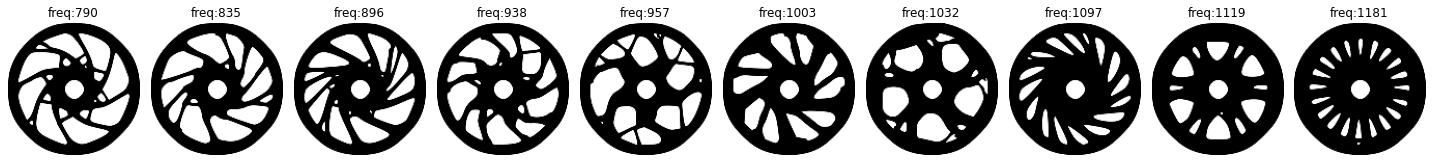

In [5]:
plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x[i],'gray')
    plt.title('freq:{}'.format(round(y[i])))
    plt.axis('off')
plt.tight_layout()
plt.show()

# Grad-CAM algorithm

In [6]:
img = x[i].reshape(1,128,128,1) # 입력 불러오기 

In [7]:
def call_grad_cam(img,target_layer= 'conv2d_5'):
    
    conv_layer = pre_model.get_layer(target_layer)
    heatmap_model = Model([pre_model.inputs], [conv_layer.output, pre_model.output])
   
    with tf.GradientTape() as gtape:
        feature_maps, predictions = heatmap_model(img)
        loss = predictions
        grads = gtape.gradient(loss, feature_maps)

    shape = feature_maps.shape
    feature_maps = np.reshape(feature_maps,(shape[1],shape[2],shape[3]))

    #특성 맵 채널별 그래디언트 평균 값이 담긴 (채널수,) 크기의 벡터
    gap_grads = K.mean(grads, axis=(0,1,2))
    gap_grads = np.array(gap_grads)

    # 각각 Feature map에 Global average pooling 된 weight를 곱해줍니다.(gradient = weight)
    zero_Arr = np.zeros(feature_maps.shape)
    for i in range(len(gap_grads)):
        zero_Arr[:,:,i] = feature_maps[:,:,i]*gap_grads[i] # 곱해서 zero arr에 넣어줌

    # feature map 채널 축으로 평균
    grad_cam = np.mean(zero_Arr,axis=-1)

    # negative 한 값(-)들 제외합니다.  
    grad_cam = np.maximum(grad_cam,0)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    grad_cam = np.maximum(grad_cam, 0) / np.max(grad_cam)

    # We rescale heatmap to a range 0-255
    grad_cam = np.uint8(255 * grad_cam)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]

    jet_grad_cam = jet_colors[grad_cam]

    pred_y = pre_model.predict(img) # 예측값
    pred_y = scaler_y.inverse_transform(pred_y)
    pred_y = np.round(pred_y)
    return pred_y, jet_grad_cam

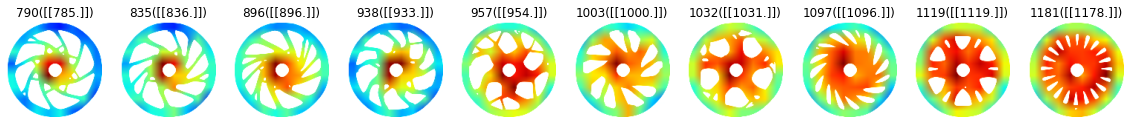

In [8]:
plt.figure(figsize=(20,4))
for i in range(len(x)):
    plt.subplot(1,10,i+1)
    img = x[i].reshape(1,128,128,1)
    true_y = round(y[i])
    pred_y, grad_cam = call_grad_cam(img,'conv2d_{}'.format(5))
    org = original_img[i]/255.
    grad_cam = cv2.resize(grad_cam,(128,128))
    overlay = org + grad_cam
    plt.imshow(overlay)
    plt.axis('off')
    plt.title('{}({})'.format(true_y,pred_y))
plt.show()